# Task results and discussion

This notebook presents the results of the task and discusses the approach taken.

## Data sources

Uniswap wallet transactions were downloaded from The Graph via its native GraphQL bindings. The `swaps` table was queried for trades in token pairs, alongside wallet addresses and quantities transacted. For token pricing, after considering a few data sources, I used Bitfinex prices, aggregated from [Cryptodatadownload.com](http://www.cryptodatadownload.com/data/bitfinex/). It was sufficient to download 600 wallets' trades to find 10 satisfying the task's criteria.

## Processing

Trades were narrowed down to 19 tokens for which pricing is available (plus WBTC, WETH and USD stablecoins), then further narrowed according to the following criteria:

- At least 5 tokens traded
- At least 20 transactions
- Active for at least 180 days

The last criterion was added to filter out wallets with a short flurry of activity but no subsequent trading.

## Comparison metrics

Wallets are ranked according to a list of criteria. Since they are generally not directly comparable (e.g. we cannot directly compare monthly return to hit rate), each portfolio will be ranked 1-10, the ranks then averaged and re-ranked for a final ranking. This gives an equal weight to all weighting methods.

In evaluating wallet performance, it is assumed the investor wants to maximise USD performance, for simplicity. This makes a big difference to the results, potentially. E.g. a USD investor who bought and hold BTC over a few years made a large profit, but an investor who denominates its wealth in BTC made no return.

The following metrics are used to rank the wallets:

#### Realised return
Monthly return of the portfolio, counting only realised PnL

#### Hit rate
Fraction of profitable trades

#### Monthly return
Monthly return of portfolio's total PnL

#### Return per trade
Total return, divided by number of transactions (as proxy for gas costs)

The following, additional metrics were also included:

#### Sharpe ratio
Realised return, divided by realised standard deviation of return (both quantities annualised). This is a key metric of performance in classic investment, as it adjusts the realised return for the risks taken.

#### Residual return
Return of the portfolio, less return of passively holding Bitcoin over the same period. This pits the wallet against a simple strategy of simply holding long the main cryptocurrency.


## Python scripts
Code below showcases the data loading pipeline and analysis tools. The underlying functionality is implemented in accompanying Python scripts:

- `queries.py` contains functionality for querying The Graph API and basic post-processing
- `bitfinex_data.py` contains functionality for parsing Bitfinex price data from csv files
- `analysis.py` contains building blocks for the analysis part of the task

Please see further remarks at the end of the notebook.

In [6]:
%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2

import queries as qq
import bitfinex_data as bd
import analysis as aa

Populating the interactive namespace from numpy and matplotlib


In [7]:
# load scraped wallets from pickle files - 600 wallets scraped
wallets_raw = aa.get_wallets('scraped*pickle')
len(wallets_raw)

600

In [8]:
# filter wallets according to the criteria above: #trades, #tokens traded, how long the wallet was active for
wallets = aa.filter_wallets(wallets_raw)
len(wallets)

10

In [9]:
# how many trades does each wallet hold?
{wallet: len(trades) for wallet, trades in wallets.items()}

{'0x0035fc5208ef989c28d47e552e92b0c507d2b318': 144,
 '0x00397d81c4b005e86df0492fd468891ad2153377': 529,
 '0x004375dff511095cc5a197a54140a24efef3a416': 7520,
 '0x004893bfbd3889b8ad13b17d793a3c7aaf5e3144': 28,
 '0x005d64b3fedd6d53edf19142087d51c7ac6ba595': 145,
 '0x00000000000080c886232e9b7ebbfb942b5987aa': 129,
 '0x000a0b24b1476f647a2a2fa4474f9ed32c685a8e': 43,
 '0x000b79f52356189c80a9d3ada3911d4438218516': 68,
 '0x00290ffc9e9d19bda7b25c6e44d8adf55dfbf2dd': 57,
 '0x002d2715b179d0db3e17cc28317a98f2f65e6884': 34}

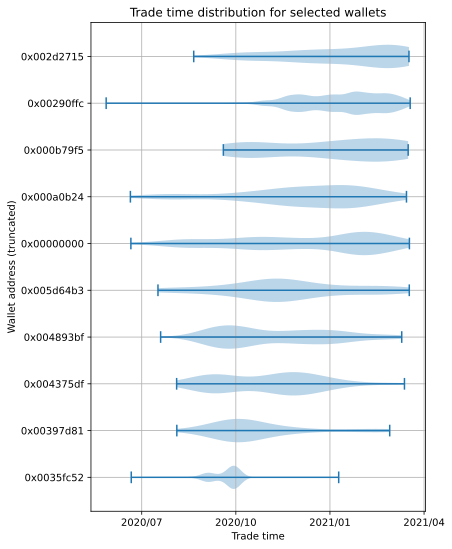

In [25]:
# plot activity span - a fair amount of variation between wallets
wallet_addrs = np.array([ wallet[:10] for wallet in wallets ])
trade_times = [ np.array([aa.datetime_to_fractional_year(trade.timestamp) 
                          for trade in trades]) 
                for trades in wallets.values() ]

avg_time = np.array([ tt.mean() for tt in trade_times ])
order = np.argsort(avg_time)

figure(figsize=(6, 9))
violinplot([trade_times[ii] for ii in order], vert=False)
plt.yticks(np.arange(10)+1, wallet_addrs)
plt.xticks([2020.5, 2020.75, 2021, 2021.25],
           ['2020/07', '2020/10', '2021/01', '2021/04'])
ylabel('Wallet address (truncated)')
xlabel('Trade time')
title('Trade time distribution for selected wallets');

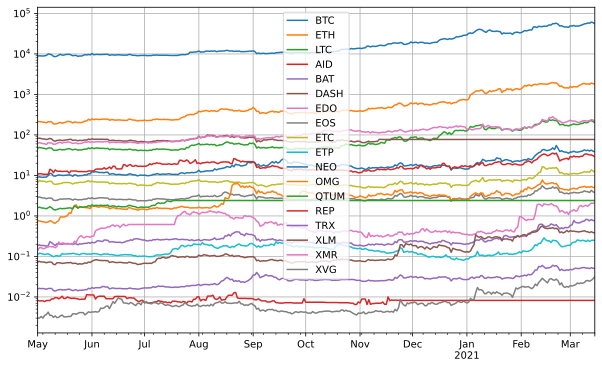

In [27]:
# plot available token prices
# prices broadly look sane; some prices flatline, possibly because currency went out of use, or because
# Bitfinex dropped coverage
# note some tokens have patchy prices, these are forward-filled, though ideally a continuous price history
# would be used
token_prices = bd.load_token_prices(bd.COVERED_TOKENS)['2020-05-01':'2021-03-15'].fillna(method='ffill')

# for plotting, remove dupes and stablecoins
token_prices_plot = token_prices.copy()
for tt in ['USDC', 'USDT', 'WETH', 'WBTC', 'DAI']:
    del token_prices_plot[tt]
    
token_prices_plot.plot(figsize=(10, 6))
yscale('log')

## Key performance statistics

The plots below show key performance statistics, such as PnL and return, reconstructed from Uniswap trades and Bitfinex token prices. Notably, all wallets show quite similar performance.

This is likely driven by the inherent "long crypto" bias of users of cryptocurrencies (as well as the difficulty of taking short positions in crypto assets off-exchange). 

Nonetheless, on closer inspection, some differences can be found. This is particularly highlighted lower down, when wallet returns are compared to a simple "buy and hold" strategy on Bitcoin.

In [39]:
# calculate 'performance_stats' which capture all calculations for subsequent analysis
all_performance_stats = {
    wallet : aa.get_wallet_performance_stats(trades, token_prices)
    for wallet, trades in wallets.items()
}

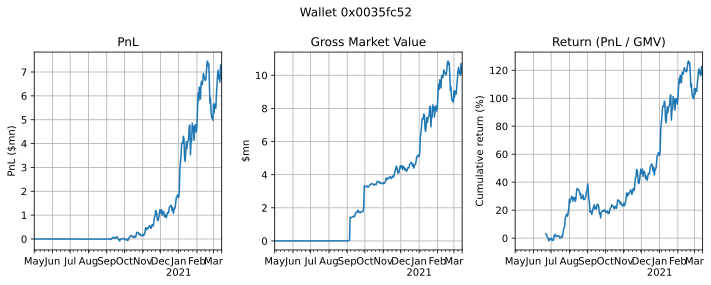

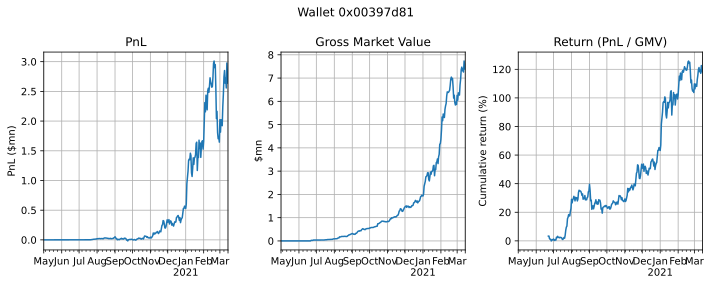

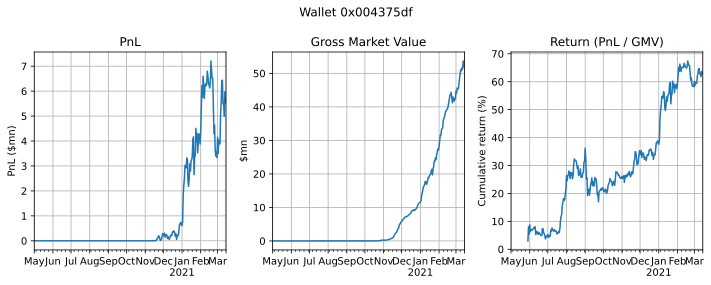

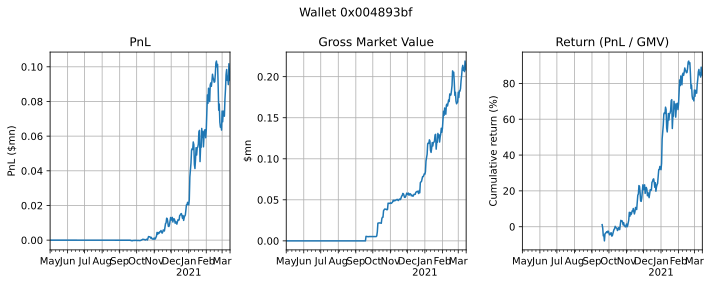

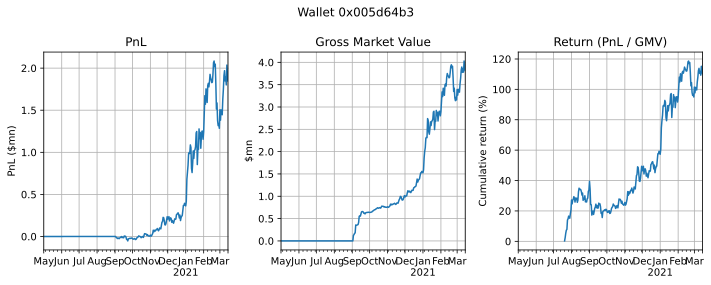

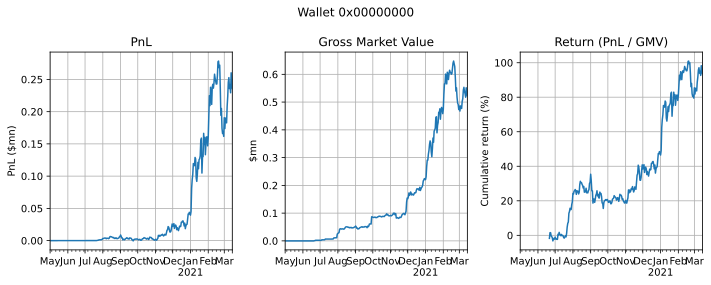

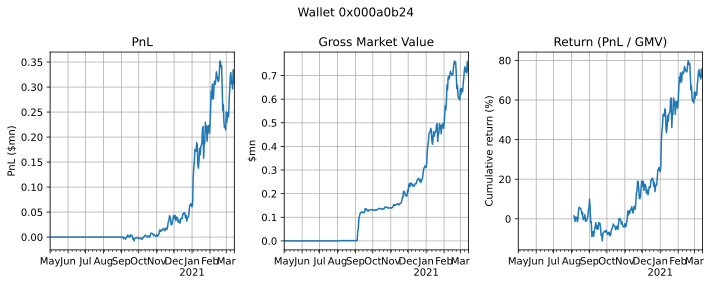

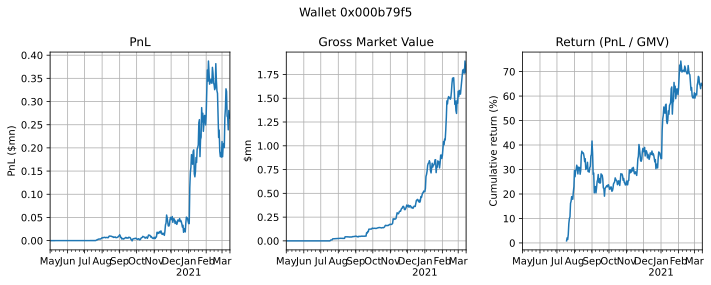

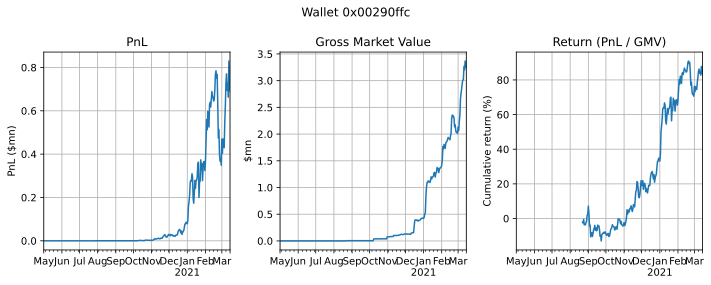

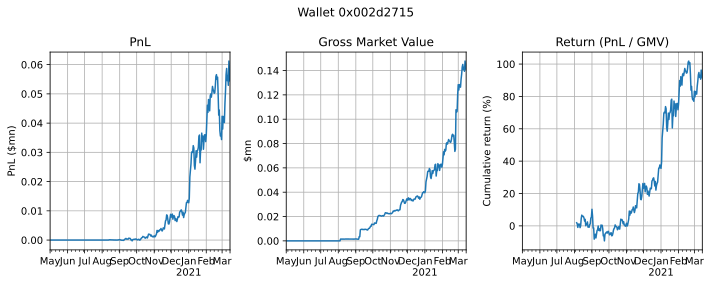

In [40]:
# for each wallet, plot its PnL and return over time
for wallet in wallets:
    # get wallet trades
    trades = wallets[wallet]
    # calculate performance statistics
    perf_stats = all_performance_stats[wallet]
    
    figure(figsize=(10, 4))
    suptitle('Wallet {}'.format(wallet[:10]))
    subplot(1, 3, 1)
    (perf_stats['pnl'] / 1e6).cumsum().plot()
    title('PnL')
    ylabel('PnL ($mn)')
    
    subplot(1, 3, 2)
    title('Gross Market Value')
    (perf_stats['GMV'] / 1e6).plot()
    ylabel('$mn')
    
    subplot(1, 3, 3)
    title('Return (PnL / GMV)')
    (perf_stats['ret'].cumsum() * 1e2).plot()
    ylabel('Cumulative return (%)')
    
    tight_layout()

## Ranking wallets

Plots below show raw ranking values, as well as the final ranking.

Despite the initial similarities, some differences now appear between the wallets. The gap in monthly returns is as large at 2x between the best and worst portfolio. There are large differences in return per _trade_, indicating that PnL after correcting for gas costs can be significant.

Most notably perhaps, only two wallets outperform a buy-and-hold BTC strategy over the period of activity.

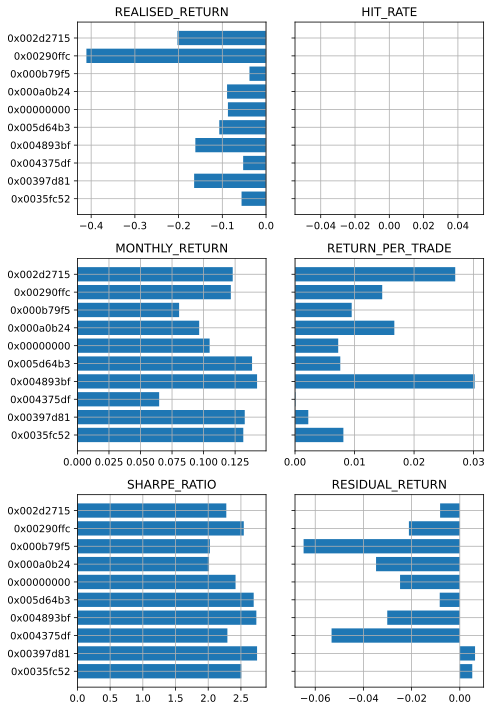

In [42]:
lrankings = []

fig, axes = subplots(3, 2, figsize=(7, 10), sharey=True)

for ii, ranking_method in enumerate(aa.RANKING_METHODS):
    ranking = np.array([
        aa.return_ranking_statistic(all_performance_stats[wallet], ranking_method, token_prices)
        for wallet in wallets
    ])
    lrankings.append(ranking)
    
    sca(axes.ravel()[ii])
    title(ranking_method)
    
    barh(np.arange(10), ranking)
    if ii % 2 == 0:
        yticks(np.arange(10), [wallet[:10] for wallet in wallets])
        
tight_layout()

In [51]:
# final ranking
def rank_data(data):
    order = np.argsort(data)
    result = np.zeros(data.shape, dtype=int)
    result[order] = np.arange(data.size)
    return result

rankings_reranked = np.vstack([ rank_data(ranking) for ranking in lrankings ])
rankings_averaged = rankings_reranked.mean(0)
final_ranking = rank_data(rankings_averaged)

print('Final ranking (higher is better)')
order = np.argsort(final_ranking)
for ii in order[::-1]:
    print(f'Wallet {list(wallets)[ii][:10]}: rank {final_ranking[ii]+1}')

Final ranking (higher is better)
Wallet 0x004893bf: rank 10
Wallet 0x002d2715: rank 9
Wallet 0x005d64b3: rank 8
Wallet 0x0035fc52: rank 7
Wallet 0x00290ffc: rank 6
Wallet 0x00397d81: rank 5
Wallet 0x00000000: rank 4
Wallet 0x000b79f5: rank 3
Wallet 0x000a0b24: rank 2
Wallet 0x004375df: rank 1


## Correlations between metrics

It is interesting to look at how the different methods of ranking wallets compare (even for this small sample). On the one hand, metrics showing positive correlation confirm each other's findings, on the other, if metrics are too correlated then they are not contributing additional information.

Crucially, realised return (i.e. realised PnL normalised by GMV) shows negative correlation to the other metrics. This makes sense, since over the period Crypto in general appreciated, thus a long-crypto-biased portfolio will show a negative tilt to stablecoins, and thus a negative realised PnL.

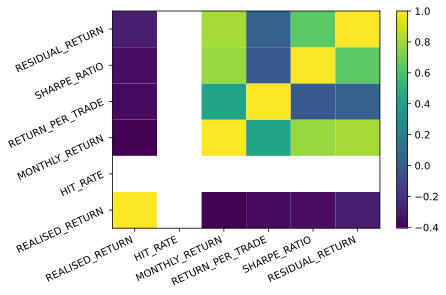

In [61]:
# another point of interest - are the rankings themselves correlated? Use rank correlation to explore
rankings_corr = np.corrcoef(np.vstack(lrankings))
assert rankings_corr.shape == (6, 6)
pcolor(rankings_corr)
colorbar()
xticks(arange(6)+0.5, aa.RANKING_METHODS, rotation=25, ha='right')
yticks(arange(6)+0.5, aa.RANKING_METHODS, rotation=25, ha='right');

array([[ 1.        ,         nan, -0.40534114, -0.36564251, -0.35349486,
        -0.28956582],
       [        nan,         nan,         nan,         nan,         nan,
                nan],
       [-0.40534114,         nan,  1.        ,  0.40775531,  0.77681732,
         0.80861805],
       [-0.36564251,         nan,  0.40775531,  1.        , -0.00977245,
         0.02653438],
       [-0.35349486,         nan,  0.77681732, -0.00977245,  1.        ,
         0.64699129],
       [-0.28956582,         nan,  0.80861805,  0.02653438,  0.64699129,
         1.        ]])

## Final remarks

### Further improvements

#### Backtest

#### Weighting ranks

### Data ambiguities

#### Field interpretation

#### Non-currency tokens

#### External trades

#### Other data sources considered

In [ ]:
%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')